In [1]:
# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine Learning Models
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.optim.lr_scheduler import StepLR

# Model for Evaluations
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, accuracy_score, precision_score, 
                             recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix)

import os

In [2]:
# Check if CUDA (GPU) is available, otherwise use CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.device(device)

# Define image transformations for data augmentation and normalization
img_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with 50% probability
    transforms.RandomVerticalFlip(p=0.5),    # Randomly flip the image vertically with 50% probability
    transforms.RandomRotation(degrees=1),    # Randomly rotate the image by 1 degree
    transforms.Resize((200, 200)),           # Resize the image 
    transforms.ToTensor()                    # Convert image to a tensor
])

# Create dataset using ImageFolder from the directory where images are stored
dataset = ImageFolder(root='/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database', transform=img_transforms)

# Split dataset into training and validation sets (70% for training, 30% for validation)
train_size = int(0.7 * len(dataset))  
val_size = len(dataset) - train_size

# Set a random seed for reproducibility
random_seed = 666
generator = torch.Generator().manual_seed(random_seed)

# Perform the split using random_split
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

# Output the number of samples in each dataset (train and validation)
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Training dataset size: 2940
Validation dataset size: 1260


In [3]:
# Set batch size for data loading
batch_size = 64

# Create DataLoader for the training dataset
train_loader = DataLoader(
    train_dataset,            # Dataset to load
    batch_size=batch_size,    # Number of samples per batch
    shuffle=True,             # Shuffle data after every epoch
    num_workers=4,            # Number of subprocesses to load data in parallel
    pin_memory=True           # If True, the data loader will copy tensors into CUDA pinned memory
)

# Create DataLoader for the validation dataset 
val_loader = DataLoader(
    val_dataset,              # Dataset to load
    batch_size=batch_size,    # Number of samples per batch
    shuffle=False,            # No need to shuffle validation data
    num_workers=4,            # Number of subprocesses to load data in parallel
    pin_memory=True           # If True, the data loader will copy tensors into CUDA pinned memory
)

# Function to visualize a batch of images from a dataloader
def visualize(dataloader):
    # Get a batch of images and labels from the dataloader
    images, labels = next(iter(dataloader))
    
    # Create a grid of images
    grid = make_grid(images, nrow=8)  # 8 images per row
    
    # Plot the grid of images
    plt.figure(figsize=(13, 13))  # Set figure size
    plt.imshow(np.transpose(grid, (1, 2, 0)))  # Convert the grid from Tensor format to numpy for plotting
    plt.axis('off')  # Turn off axes
    plt.show()

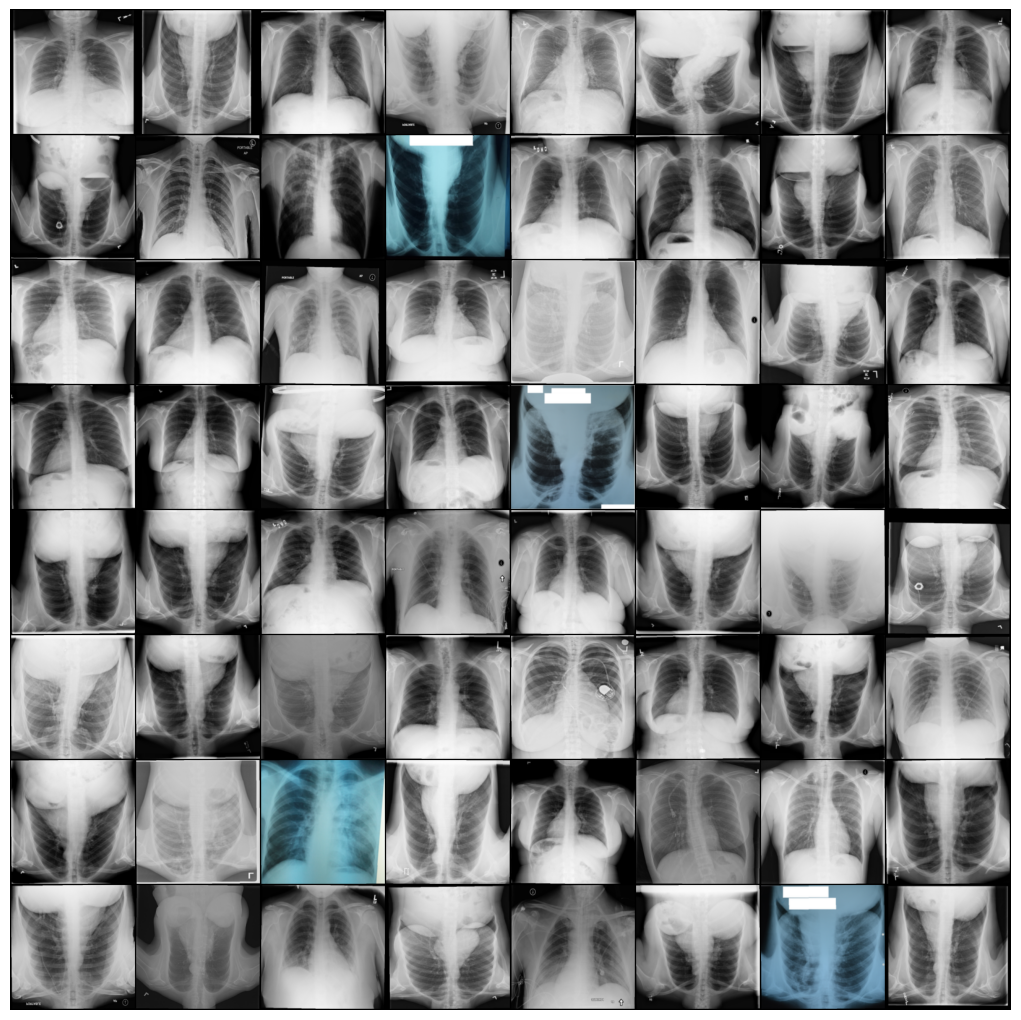

In [4]:
# Visualize a batch of images from the validation dataset
visualize(val_loader)

In [5]:
class CNN(nn.Module):
    def __init__(self, num_classes, dropout_rate):
        super(CNN, self).__init__()
        
        self.features = nn.Sequential(
            
            # Feature extraction layers (Conv + BN + ReLU + Pooling)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # Downsampling
            nn.MaxPool2d(2, 2),  


            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # Downsampling
            nn.MaxPool2d(2, 2),   


            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # Downsampling
            nn.MaxPool2d(2, 2),  
        )
        
        # Global average pooling 
        self.gap = nn.AdaptiveAvgPool2d(1)  
        
        # Fully connected classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)   # extract features
        x = self.gap(x)        # global average pooling
        x = self.classifier(x) # classification head
        return x

In [6]:
# Create an instance of the CNN model and move it to the appropriate device (GPU or CPU)
model = CNN(num_classes=2,dropout_rate=0.15).to(device)

# Initialize the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001) 

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Scheduler to adjust the learning rate
scheduler = StepLR(optimizer, step_size=5, gamma=0.85)

In [7]:
# Training function
def train(train_loader):
    model.train()  # Set the model to training mode
    total_loss = total_samples = total_correct = 0
    y_true = []
    y_pred = []

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Clear previous gradients

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        loss.backward()

        # Clip gradients to a maximum norm of 1.0 to prevent exploding gradients and stabilize training
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        total_loss += loss.item() * images.size(0)  # Accumulate loss
        total_samples += images.size(0)

        y_true.append(labels.cpu().numpy())
        y_pred.append(outputs.argmax(dim=1).cpu().numpy())

        # Calculate accuracy for this batch
        correct = (outputs.argmax(dim=1) == labels).sum().item()
        total_correct += correct

    # Calculate average loss and accuracy for the training set
    accuracy = total_correct / total_samples * 100
    return total_loss / total_samples, accuracy

# Validation function
@torch.no_grad()  # Disable gradient calculations for validation to save memory and computation
def val(val_loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = total_samples = total_correct = 0
    y_true = []
    y_pred = []

    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        total_loss += loss.item() * images.size(0)  # Accumulate loss
        total_samples += images.size(0)

        y_true.append(labels.cpu().numpy())
        y_pred.append(outputs.argmax(dim=1).cpu().numpy())

        # Calculate accuracy for this batch
        correct = (outputs.argmax(dim=1) == labels).sum().item()
        total_correct += correct

    # Calculate average loss and accuracy for the validation set
    accuracy = total_correct / total_samples * 100
    return total_loss / total_samples, accuracy

In [8]:
# Initialize lists to store training and validation losses and accuracies
training_loss = []
validation_loss = []
training_acc = []
validation_acc = []

# Number of epochs
epochs = 12

# Training and validation loop
for epoch in range(epochs):
    # Train the model and get the training loss and accuracy
    train_loss, train_accuracy = train(train_loader)

    # Adjust the learning rate
    scheduler.step()

    # Validate the model and get the validation loss and accuracy
    val_loss, val_accuracy = val(val_loader)

    # Append the results to the lists
    training_loss.append(train_loss)
    training_acc.append(train_accuracy)
    validation_loss.append(val_loss)
    validation_acc.append(val_accuracy)

    # Print progress for this epoch
    print(f"Epoch: {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch: 1/12 | Train Loss: 0.3266, Train Accuracy: 91.02% | Val Loss: 0.3541, Val Accuracy: 91.67%
Epoch: 2/12 | Train Loss: 0.1920, Train Accuracy: 94.22% | Val Loss: 0.1848, Val Accuracy: 94.76%
Epoch: 3/12 | Train Loss: 0.1623, Train Accuracy: 94.93% | Val Loss: 0.1593, Val Accuracy: 94.44%
Epoch: 4/12 | Train Loss: 0.1487, Train Accuracy: 95.10% | Val Loss: 0.1389, Val Accuracy: 96.43%
Epoch: 5/12 | Train Loss: 0.1287, Train Accuracy: 96.02% | Val Loss: 0.1139, Val Accuracy: 95.71%
Epoch: 6/12 | Train Loss: 0.1047, Train Accuracy: 96.73% | Val Loss: 0.1040, Val Accuracy: 97.86%
Epoch: 7/12 | Train Loss: 0.0863, Train Accuracy: 97.28% | Val Loss: 0.0861, Val Accuracy: 97.46%
Epoch: 8/12 | Train Loss: 0.0738, Train Accuracy: 97.99% | Val Loss: 0.0697, Val Accuracy: 98.33%
Epoch: 9/12 | Train Loss: 0.0644, Train Accuracy: 98.23% | Val Loss: 0.0676, Val Accuracy: 97.94%
Epoch: 10/12 | Train Loss: 0.0620, Train Accuracy: 98.20% | Val Loss: 0.1431, Val Accuracy: 96.27%
Epoch: 11/12 | Trai

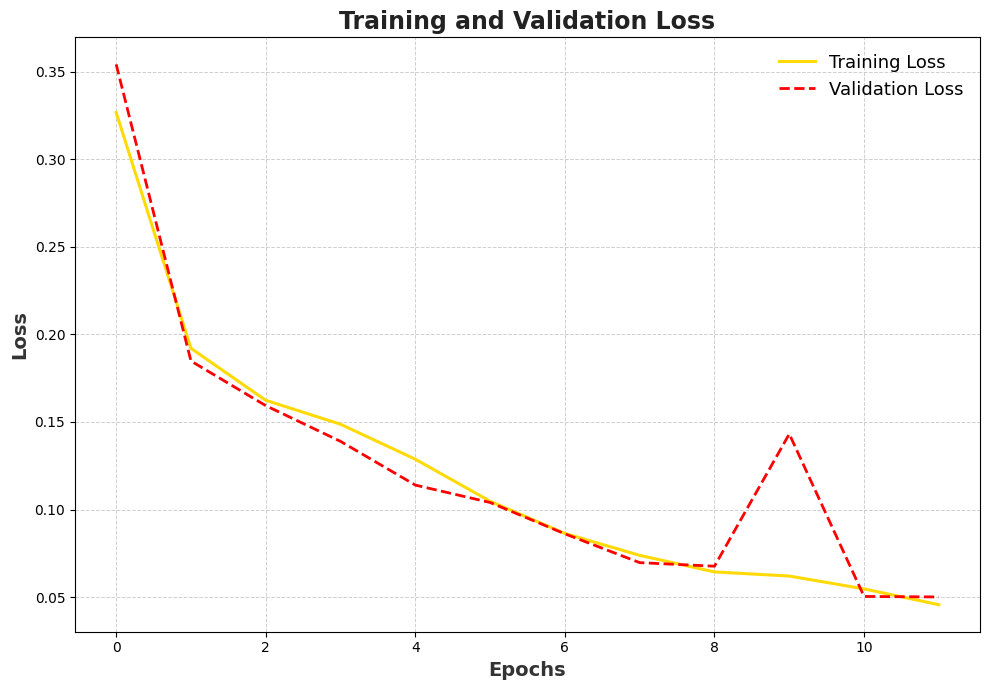

In [9]:
# Choose a style for the plot
plt.style.use("default")

# Create figure
plt.figure(figsize=(10, 7))

# Plot training and validation loss
plt.plot(range(epochs), training_loss, label='Training Loss', 
         color='#ffda06', linestyle='-', linewidth=2.2, alpha=1)

plt.plot(range(epochs), validation_loss, label='Validation Loss', 
         color='red', linestyle='--', linewidth=2, alpha=1)

# Labels and title
plt.xlabel('Epochs', fontsize=14, fontweight='bold', color='#333333')
plt.ylabel('Loss', fontsize=14, fontweight='bold', color='#333333')
plt.title('Training and Validation Loss', fontsize=17, fontweight='bold', color='#222222')

plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)

plt.legend(loc='upper right', fontsize=13, frameon=False)

# Adjust layout for a clean look
plt.tight_layout()
plt.show()

In [10]:
@torch.no_grad()
def eval(loader):
    model.eval()  # Set the model to evaluation mode
    preds, trues = [], []

    for images, labels in loader:
        images = images.to(device)  # Move images to the device (GPU/CPU)
        labels = labels.to(device)  # Move labels to the device (GPU/CPU)

        # Forward pass: Get logits (raw output from the model)
        outputs = model(images)
        
        # Convert logits to probabilities (softmax for multi-class classification)
        probs = torch.softmax(outputs, dim=1)  # Use softmax to get probabilities for each class
        
        preds.append(probs.cpu())  # Store the predicted probabilities on CPU
        trues.append(labels.cpu())  # Store the true labels on CPU

    # Concatenate the results from each batch
    preds = torch.cat(preds).numpy()  # Predicted probabilities
    trues = torch.cat(trues).numpy()  # True labels

    # Get the predicted class by taking the argmax of the probabilities
    predicted_classes = preds.argmax(axis=1)

    # Create a DataFrame to store the true labels, predicted probabilities, and predicted classes
    df_result = pd.DataFrame({
        'actual': trues,
        'probability': list(preds),
        'pred': predicted_classes
    })

    return df_result

In [11]:
# Evaluate the model on validation data
val_res = eval(val_loader)

# Retrieve class names from dataset
class_names = dataset.classes

# Calculate evaluation metrics
print(classification_report(val_res['actual'], val_res['pred'], target_names=class_names))

              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99      1038
Tuberculosis       1.00      0.91      0.96       222

    accuracy                           0.98      1260
   macro avg       0.99      0.96      0.97      1260
weighted avg       0.99      0.98      0.98      1260



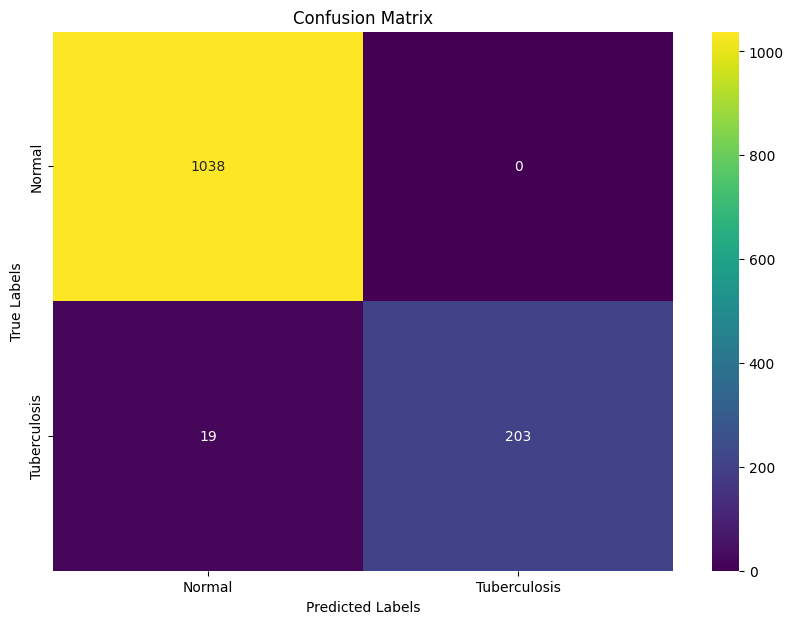

In [12]:
# Calculate confusion matrix to compare actual vs predicted labels
ConfusionMatrix = confusion_matrix(val_res['actual'], val_res['pred'])

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(10, 7))  # Set figure size

# Plot the confusion matrix with annotations and class names
sns.heatmap(ConfusionMatrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='viridis')

# Add labels and title to the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Show the plot
plt.show()

In [13]:
# Save the trained model weights after training
torch.save(model.state_dict(), 'model_weights.pth')